# [DistilBERT, a distilled version of BERT: smaller, faster, cheaper and lighter](https://arxiv.org/abs/1910.01108)

In this lecture, we will explore the architecture of DistilBERT, its key components, and how it can be utilized for various natural language processing tasks. Additionally, we'll discuss its advantages, limitations, and provide hands-on examples to showcase its effectiveness.

Reference : [The Theory](https://towardsdatascience.com/distillation-of-bert-like-models-the-code-73c31e8c2b0a) | [Code](https://towardsdatascience.com/distillation-of-bert-like-models-the-theory-32e19a02641f)

In [1]:
import os

In [2]:
# !pip install datasets --upgrade
import datasets
import transformers
import torch
datasets.__version__, transformers.__version__, torch.__version__

c:\Users\Acer\.conda\envs\nlp-env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


('2.16.1', '4.38.2', '2.2.0+cu118')

In [3]:
import torch.nn as nn
import torch
from tqdm.auto import tqdm
import random, math, time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

#make our work comparable if restarted the kernel
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

cuda


## 1. Loading our MNLI part of the GLUE dataset

In [4]:
import datasets

###1. Load Dataset
task_to_keys = {
    "cola": ("sentence", None),
    "mnli": ("premise", "hypothesis"),
    "mrpc": ("sentence1", "sentence2"),
    "qnli": ("question", "sentence"),
    "qqp": ("question1", "question2"),
    "rte": ("sentence1", "sentence2"),
    "sst2": ("sentence", None),
    "stsb": ("sentence1", "sentence2"),
    "wnli": ("sentence1", "sentence2"),
}

task_name = "mnli"
raw_datasets = datasets.load_dataset("glue", task_name)
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 392702
    })
    validation_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9815
    })
    validation_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9832
    })
    test_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9796
    })
    test_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9847
    })
})

In [5]:
label_list = raw_datasets['train'].features['label'].names
label2id = {v: i for i, v in enumerate(label_list)}
label2id

{'entailment': 0, 'neutral': 1, 'contradiction': 2}

In [6]:
id2label = {i: v for v, i in label2id.items()}
id2label

{0: 'entailment', 1: 'neutral', 2: 'contradiction'}

## 2. Model & Tokenization

In [7]:
import numpy as np 
num_labels = np.unique(raw_datasets['train']['label']).size
num_labels

3

In [8]:
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer

teacher_id = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(teacher_id)

teacher_model = AutoModelForSequenceClassification.from_pretrained(
    teacher_id, 
    num_labels = num_labels,
    id2label = id2label,
    label2id = label2id,
)

teacher_model

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

## 3. Preprocessing 

In [9]:
def tokenize_function(examples):
    sentence1_key, sentence2_key = task_to_keys[task_name]
    args = (
        (examples[sentence1_key],) if sentence2_key is None else (examples[sentence1_key], examples[sentence2_key])
    )
    result = tokenizer(*args, max_length=128, truncation=True)
    return result

In [10]:
tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
tokenized_datasets

Map:   0%|          | 0/9796 [00:00<?, ? examples/s]

Map: 100%|██████████| 9796/9796 [00:00<00:00, 15979.00 examples/s]


DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 392702
    })
    validation_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9815
    })
    validation_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9832
    })
    test_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9796
    })
    test_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9847
    })
})

In [11]:
# list(task_to_keys[task_name])
column_dataset = [item for item in task_to_keys[task_name] if item is not None]
column_dataset

['premise', 'hypothesis']

In [12]:
#remove column : 'premise', 'hypothesis', 'idx'
tokenized_datasets = tokenized_datasets.remove_columns(column_dataset + ["idx"])
#rename column : 'labels'
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format("torch")
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 392702
    })
    validation_matched: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9815
    })
    validation_mismatched: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9832
    })
    test_matched: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9796
    })
    test_mismatched: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9847
    })
})

In [13]:
tokenized_datasets['train'][0]['input_ids']

tensor([  101, 17158,  2135,  6949,  8301, 25057,  2038,  2048,  3937,  9646,
         1011,  4031,  1998, 10505,  1012,   102,  4031,  1998, 10505,  2024,
         2054,  2191,  6949,  8301, 25057,  2147,  1012,   102])

In [14]:
tokenizer.decode(tokenized_datasets['train'][0]['input_ids'])

'[CLS] conceptually cream skimming has two basic dimensions - product and geography. [SEP] product and geography are what make cream skimming work. [SEP]'

## 4. Preparing the dataloader

In [15]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
#Data collator that will dynamically pad the inputs received.

In [16]:
small_train_dataset = tokenized_datasets["train"].shuffle(seed=1150).select(range(10000))
small_eval_dataset = tokenized_datasets["validation_mismatched"].shuffle(seed=1150).select(range(1000))
small_test_dataset = tokenized_datasets["test_mismatched"].shuffle(seed=1150).select(range(1000))

In [17]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(
    small_train_dataset, shuffle=True, batch_size=32, collate_fn=data_collator)
test_dataloader = DataLoader(
    small_test_dataset, batch_size=32, collate_fn=data_collator)
eval_dataloader = DataLoader(
    small_eval_dataset, batch_size=32, collate_fn=data_collator)

In [18]:
for batch in train_dataloader:
    break
    
batch['labels'].shape, batch['input_ids'].shape, batch['attention_mask'].shape

(torch.Size([32]), torch.Size([32, 121]), torch.Size([32, 121]))

## 5. Design the model and losses

### 5.1 Teacher Model & Student Model

####  Architecture 
In the present work, the student - DistilBERT - has the same general architecture as BERT. 
- The `token-type embeddings` and the `pooler` are removed while `the number of layers` is reduced by a factor of 2. 
- Most of the operations used in the Transformer architecture `linear layer` and `layer normalisation` are highly optimized in modern linear algebra frameworks.
- our investigations showed that variations on the last dimension of the tensor (hidden size dimension) have a smaller impact on computation efficiency (for a fixed parameters budget) than variations on other factors like the number of layers. 
- Thus we focus on reducing the number of layers.

#### Initialize Student Model
- To initialize a new model from an existing one, we need to access the weights of the old model (the teacher). 
- In order to get the weights, we first have to know how to access them. We’ll use BERT as our teacher model.

In [19]:
teacher_model.config

BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "entailment",
    "1": "neutral",
    "2": "contradiction"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "contradiction": 2,
    "entailment": 0,
    "neutral": 1
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.38.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

#### 
- The student model has the same configuration, except the number of layers is reduced by a factor of 2
- The student layers are initilized by copying one out of two layers of the teacher, starting with layer 0.
- The head of the teacher is also copied.

In [20]:
from transformers.models.bert.modeling_bert import BertPreTrainedModel, BertConfig
# Get teacher configuration as a dictionnary
configuration = teacher_model.config.to_dict()
# configuration

In [21]:
# Half the number of hidden layer
configuration['num_hidden_layers'] //= 2
# Convert the dictionnary to the student configuration
configuration = BertConfig.from_dict(configuration)

In [22]:
# Create uninitialized student model
model = type(teacher_model)(configuration)
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-5): 6 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, e

- Recursively copies the weights of the (teacher) to the (student).
- This function is meant to be first called on a BertFor... model, but is then called on every children of that model recursively.
- The only part that's not fully copied is the encoder, of which only half is copied.

In [23]:
from transformers.models.bert.modeling_bert import BertEncoder, BertModel
from torch.nn import Module

def distill_bert_weights(
    teacher : Module,
    student : Module,
    init_method = 'top'
) -> None:
    """
    Recursively copies the weights of the (teacher) to the (student).
    This function is meant to be first called on a BertFor... model, but is then called on every children of that model recursively.
    The only part that's not fully copied is the encoder, of which only half is copied.
    """
    # If the part is an entire BERT model or a BERTFor..., unpack and iterate
    if isinstance(teacher, BertModel) or type(teacher).__name__.startswith('BertFor'):
        for teacher_part, student_part in zip(teacher.children(), student.children()):
            distill_bert_weights(teacher_part, student_part)
    # Else if the part is an encoder, copy one out of every layer
    elif isinstance(teacher, BertEncoder):
        teacher_encoding_layers = [layer for layer in next(teacher.children())] #12 layers
        student_encoding_layers = [layer for layer in next(student.children())] #6 layers

        if init_method == 'top':
            for i in range(len(student_encoding_layers)):
                student_encoding_layers[i].load_state_dict(teacher_encoding_layers[i].state_dict())

        elif init_method == 'bottom':
            for i in range(len(student_encoding_layers)):
                student_encoding_layers[i].load_state_dict(teacher_encoding_layers[i+len(student_encoding_layers)].state_dict())

        elif init_method == 'odd':
            for i in range(len(student_encoding_layers)):
                student_encoding_layers[i].load_state_dict(teacher_encoding_layers[i*2-1].state_dict())

        elif init_method == 'even':
            for i in range(len(student_encoding_layers)):
                student_encoding_layers[i].load_state_dict(teacher_encoding_layers[i*2].state_dict())

        else:
            raise Exception("init_method is invalid. Select between 'top', 'bottom', 'odd', 'even'")

    # Else the part is a head or something else, copy the state_dict
    else:
        student.load_state_dict(teacher.state_dict())

    return model

In [24]:
# model = distill_bert_weights(teacher=teacher_model, student=model)

In [25]:
# models dictionary will store different student models initialized with distilled weights
models = {
    # Distill using top-K layer initialization method
    'Top-K Layer': distill_bert_weights(teacher=teacher_model, student=model, init_method='top'),
    
    # Distill using bottom-K layer initialization method
    'Bottom-K Layer': distill_bert_weights(teacher=teacher_model, student=model, init_method='bottom'),
    
    # Distill using even layer initialization method
    'Even Layer': distill_bert_weights(teacher=teacher_model, student=model, init_method='even'),
    
    # Distill using odd layer initialization method
    'Odd Layer': distill_bert_weights(teacher=teacher_model, student=model, init_method='odd')
}


In [26]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print('Teacher parameters :', count_parameters(teacher_model))
# print('Teacher parameters :', count_parameters(teacher_model))
# print('Student parameters :', count_parameters(model))
for model_name, model in models.items():
    print(f'Student ({model_name}) parameters :', count_parameters(model))

Teacher parameters : 109484547
Student (Top-K Layer) parameters : 66957315
Student (Bottom-K Layer) parameters : 66957315
Student (Odd Layer) parameters : 66957315
Student (Even Layer) parameters : 66957315


We can see the number of parameter in the student model are same.

In [27]:
count_parameters(models['Top-K Layer'])/count_parameters(teacher_model) * 100

61.15686353435797

In [28]:
#It has 40% less parameters than bert-base-uncased

### 5.2 Loss function

#### Softmax

$$
P_i(\mathbf{z}_i, T) = \frac{\exp(\mathbf{z}_i / T)}{\sum_{q=0}^k \exp(\mathbf{z}_q / T)}
$$


#### Knowledge Distillation

#### CE Loss
$$\mathcal{L}_\text{CE} = -\sum^N_{j=0}\sum_{i=0}^k {y}_i^{(j)}\log(P_i({v}_i^{(j)}, 1))$$

#### KL Loss
$$\mathcal{L}_\text{KD} = -\sum^N_{j=0}\sum_{i=0}^k P_i({z}_i^{(j)}, T) \log (P_i({v}_i^{(j)}, T))$$

#### Cosine Embedding Loss
$$\mathcal{L}_{\text{cosine}}(x_1, x_2, y) = \frac{1}{N} \sum_{i=1}^{N} \left(1 - y_i \cdot \cos(\theta_i)\right)$$

<!-- $$\mathcal{L} = \lambda \mathcal{L}_\text{KD} + (1-\lambda)\mathcal{L}_\text{CE}$$
 -->

#### Total Loss
$$\mathcal{L} = \mathcal{L}_\text{KD} + \mathcal{L}_\text{CE} + \mathcal{L}_{\text{cosine}}$$

In [29]:
import torch.nn.functional as F

class DistillKL(nn.Module):
    """
    Distilling the Knowledge in a Neural Network
    Compute the knowledge-distillation (KD) loss given outputs, labels.
    "Hyperparameters": temperature and alpha

    NOTE: the KL Divergence for PyTorch comparing the softmaxs of teacher
    and student expects the input tensor to be log probabilities! 
    """

    def __init__(self):
        super(DistillKL, self).__init__()

    def forward(self, output_student, output_teacher, temperature=1):
        '''
        Note: the output_student and output_teacher are logits 
        '''
        T = temperature #.cuda()
        
        KD_loss = nn.KLDivLoss(reduction='batchmean')(
            F.log_softmax(output_student/T, dim=-1),
            F.softmax(output_teacher/T, dim=-1)
        ) * T * T
        
        return KD_loss

In [30]:
criterion_div = DistillKL()
criterion_cos = nn.CosineEmbeddingLoss()

## 6. Optimizer

In [31]:
import torch.optim as optim
import torch.nn as nn

lr = 5e-5

#training hyperparameters
optimizer = optim.Adam(params=model.parameters(), lr=lr)

In [32]:
model = model.to(device)
teacher_model = teacher_model.to(device)

## 7. Learning rate scheduler

In [33]:
from transformers import get_scheduler

num_epochs = 3
num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = num_epochs * num_update_steps_per_epoch

lr_scheduler = get_scheduler(
    name="linear", 
    optimizer=optimizer, 
    num_warmup_steps=0, 
    num_training_steps=num_training_steps
)

## 8. Metric

In [34]:
!pip3 install evaluate

In [35]:
import numpy as np
import evaluate
# Get the metric function
if task_name is not None:
    metric = evaluate.load("glue", task_name)
else:
    metric = evaluate.load("accuracy")

## 9. Train

In [36]:
import torch
from tqdm.auto import tqdm
# progress_bar = tqdm(range(num_training_steps))
# eval_metrics = 0

model_scores = {}

for model_name, model in models.items():

    print(f"\n {model_name}")

    progress_bar = tqdm(range(num_training_steps))
    eval_metrics = 0

    train_losses = []
    train_losses_cls = []
    train_losses_div = []
    train_losses_cos = []
    eval_losses = []
    eval_accuracies = []  

    for epoch in range(num_epochs):
        model.train()
        teacher_model.eval()
        train_loss = 0
        train_loss_cls = 0
        train_loss_div = 0
        train_loss_cos = 0
        
        for batch in train_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            # compute student output
            outputs = model(**batch) 
            # compute teacher output
            with torch.no_grad():
                output_teacher = teacher_model(**batch)

            # assert size
            assert outputs.logits.size() == output_teacher.logits.size()
            
            # cls loss 
            loss_cls  = outputs.loss
            train_loss_cls += loss_cls.item()
            # distillation loss
            loss_div = criterion_div(outputs.logits, output_teacher.logits)
            train_loss_div += loss_div.item()
            # cosine loss
            loss_cos = criterion_cos(output_teacher.logits, outputs.logits, torch.ones(output_teacher.logits.size()[0]).to(device))
            train_loss_cos += loss_cos.item()
            
            # Average the loss and return it
            loss = (loss_cls + loss_div + loss_cos) / 3
            
            train_loss += loss.item()
            loss.backward()
            # accelerator.backward(loss)
            # Step with optimizer
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
            progress_bar.update(1)
            
        train_losses.append(train_loss / len(train_dataloader))
        train_losses_cls.append(train_loss_cls / len(train_dataloader))
        train_losses_div.append(train_loss_div / len(train_dataloader))
        train_losses_cos.append(train_loss_cos / len(train_dataloader))

        print(f'Epoch at {epoch+1}: Train loss {train_loss/len(train_dataloader):.4f}:')
        print(f'  - Loss_cls: {train_loss_cls/len(train_dataloader):.4f}')
        print(f'  - Loss_div: {train_loss_div/len(train_dataloader):.4f}')
        print(f'  - Loss_cos: {train_loss_cos/len(train_dataloader):.4f}')
        
        model.eval()
        eval_loss = 0
        for batch in eval_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            with torch.no_grad():
                outputs = model(**batch)
                
            loss_cls = outputs.loss
            predictions = outputs.logits.argmax(dim=-1)

            eval_loss += loss_cls.item()
            # predictions, references = accelerator.gather((predictions, batch["labels"]))
            metric.add_batch(
                predictions=predictions, 
                references=batch["labels"])
            
        eval_metric = metric.compute()
        eval_metrics += eval_metric['accuracy'] 
        eval_losses.append(eval_loss / len(eval_dataloader))  # Save the evaluation loss for plotting
        eval_accuracies.append(eval_metric['accuracy'])  

        print(f"Epoch at {epoch+1}: Test Acc {eval_metric['accuracy']:.4f}")
        
    print('Avg Metric', eval_metrics/num_epochs)

    model_scores[model_name] = {
        'train_loss': train_losses,
        'train_loss_cls': train_losses_cls,
        'train_loss_div': train_losses_div,
        'train_loss_cos': train_losses_cos,
        'eval_losse': eval_losses,
        'eval_accuracie': eval_accuracies  
    }
    
    progress_bar.reset()



 Top-K Layer


 33%|███▎      | 313/939 [07:00<09:17,  1.12it/s]

Epoch at 1: Train loss 0.3508:
  - Loss_cls: 0.9529
  - Loss_div: 0.0509
  - Loss_cos: 0.0488
Epoch at 1: Test Acc 0.6480


 67%|██████▋   | 626/939 [12:06<03:30,  1.49it/s]

Epoch at 2: Train loss 0.3064:
  - Loss_cls: 0.7606
  - Loss_div: 0.1109
  - Loss_cos: 0.0477
Epoch at 2: Test Acc 0.6670


100%|██████████| 939/939 [19:31<00:00,  1.35s/it]

Epoch at 3: Train loss 0.2754:
  - Loss_cls: 0.6216
  - Loss_div: 0.1559
  - Loss_cos: 0.0487


  0%|          | 0/939 [00:00<?, ?it/s]          

Epoch at 3: Test Acc 0.6660
Avg Metric 0.6603333333333333

 Bottom-K Layer


  0%|          | 0/939 [00:00<?, ?it/s]


Epoch at 1: Train loss 0.2660:
  - Loss_cls: 0.5827
  - Loss_div: 0.1664
  - Loss_cos: 0.0488
Epoch at 1: Test Acc 0.6660


Epoch at 2: Train loss 0.2664:
  - Loss_cls: 0.5841
  - Loss_div: 0.1663
  - Loss_cos: 0.0487
Epoch at 2: Test Acc 0.6660


Epoch at 3: Train loss 0.2660:
  - Loss_cls: 0.5835
  - Loss_div: 0.1658
  - Loss_cos: 0.0486


Epoch at 3: Test Acc 0.6660
Avg Metric 0.666

 Odd Layer


 33%|███▎      | 313/939 [07:13<12:23,  1.19s/it]

Epoch at 1: Train loss 0.2658:
  - Loss_cls: 0.5822
  - Loss_div: 0.1661
  - Loss_cos: 0.0490
Epoch at 1: Test Acc 0.6660


 67%|██████▋   | 626/939 [14:37<06:09,  1.18s/it]

Epoch at 2: Train loss 0.2655:
  - Loss_cls: 0.5796
  - Loss_div: 0.1678
  - Loss_cos: 0.0491
Epoch at 2: Test Acc 0.6660


100%|██████████| 939/939 [22:02<00:00,  1.29s/it]

Epoch at 3: Train loss 0.2662:
  - Loss_cls: 0.5837
  - Loss_div: 0.1660
  - Loss_cos: 0.0487


  0%|          | 0/939 [00:00<?, ?it/s]          

Epoch at 3: Test Acc 0.6660
Avg Metric 0.666

 Even Layer


  0%|          | 0/939 [00:00<?, ?it/s]


Epoch at 1: Train loss 0.2655:
  - Loss_cls: 0.5814
  - Loss_div: 0.1663
  - Loss_cos: 0.0489
Epoch at 1: Test Acc 0.6660


Epoch at 2: Train loss 0.2661:
  - Loss_cls: 0.5827
  - Loss_div: 0.1667
  - Loss_cos: 0.0489
Epoch at 2: Test Acc 0.6660


Epoch at 3: Train loss 0.2662:
  - Loss_cls: 0.5837
  - Loss_div: 0.1660
  - Loss_cos: 0.0489


Epoch at 3: Test Acc 0.6660
Avg Metric 0.666


In [42]:
for model_name, scores in model_scores.items():
    print(f"\nModel Name: {model_name}")
    print(f"Train Losses: {scores['train_loss'][-1]:.4f}")
    print(f"Eval Losses: {scores['eval_losse'][-1]:.4f}")
    print(f"Eval Accuracy: {scores['eval_accuracie'][-1]:.4f}")



Model Name: Top-K Layer
Train Losses: 0.2754
Eval Losses: 0.7990
Eval Accuracy: 0.6660

Model Name: Bottom-K Layer
Train Losses: 0.2660
Eval Losses: 0.7990
Eval Accuracy: 0.6660

Model Name: Odd Layer
Train Losses: 0.2662
Eval Losses: 0.7990
Eval Accuracy: 0.6660

Model Name: Even Layer
Train Losses: 0.2662
Eval Losses: 0.7990
Eval Accuracy: 0.6660


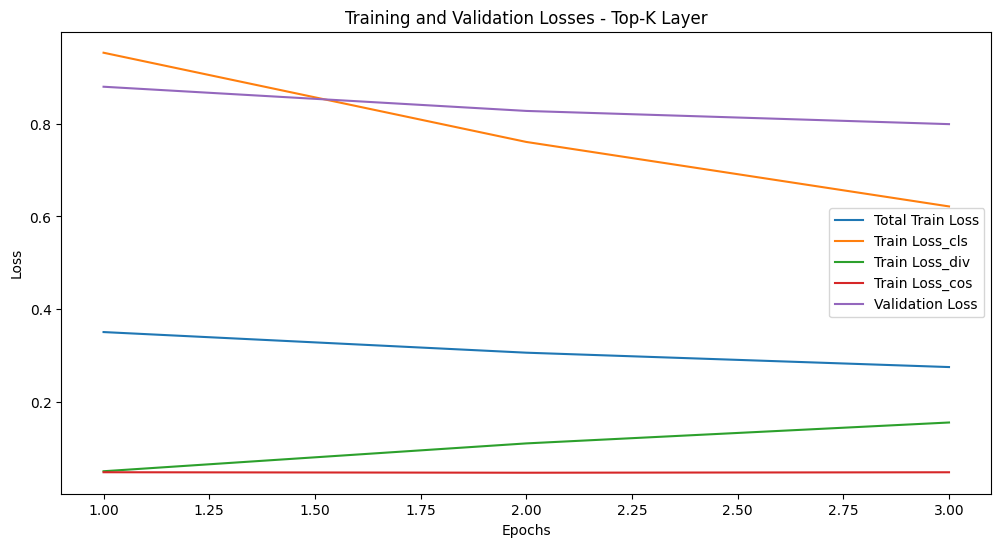

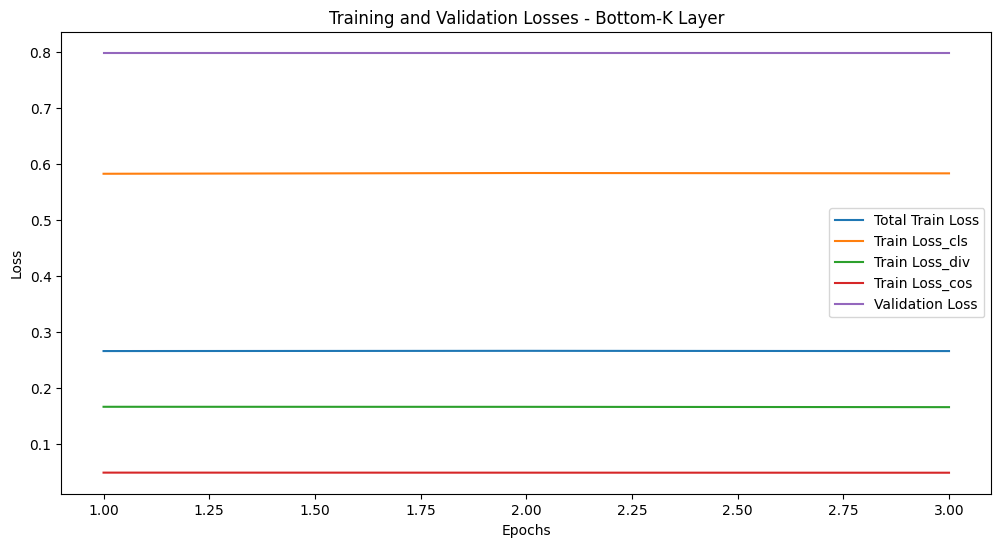

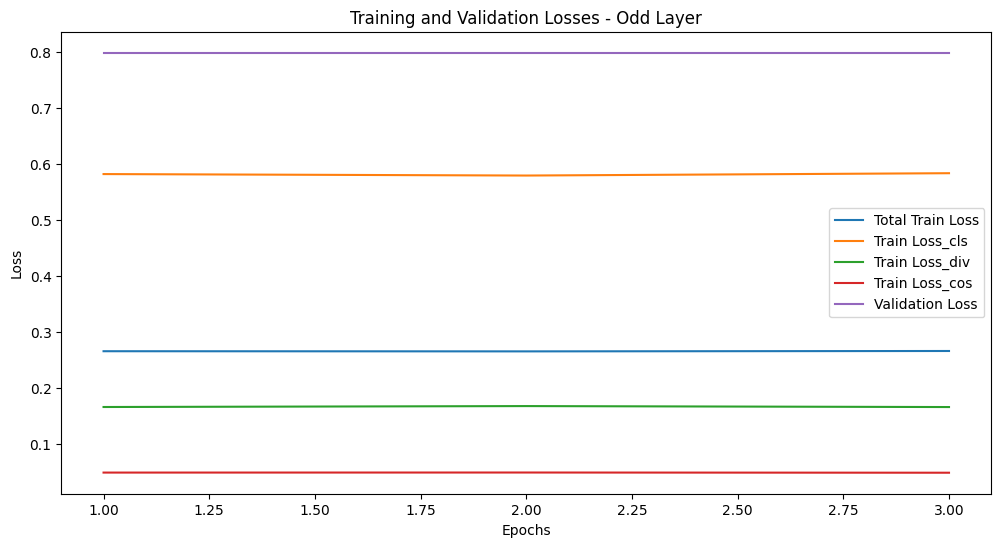

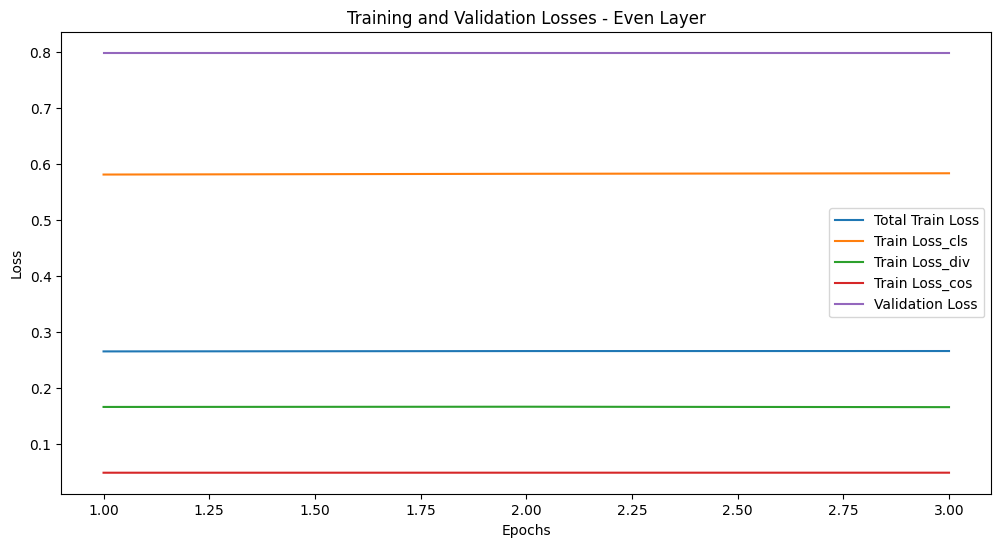

In [ ]:
import matplotlib.pyplot as plt

# model_names contains the names of different models for which scores are available
model_names = list(model_scores.keys())

# Iterate through each model to plot its training and validation losses
for model_name in model_names:
    # Extract the scores for the current model
    scores = model_scores[model_name]

    # Extract different types of losses from the scores
    train_losses = scores['train_loss']  # Total training loss
    train_losses_cls = scores['train_loss_cls']  # Classification loss during training
    train_losses_div = scores['train_loss_div']  # Divergence loss during training
    train_losses_cos = scores['train_loss_cos']  # Cosine similarity loss during training
    eval_losses = scores['eval_losses']  # Validation loss

    # Generate a list of epochs for the x-axis of the plot
    epochs_list = range(1, num_epochs + 1)

    # Create a new figure for each model's plot
    plt.figure(figsize=(12, 6))
    
    # Plot different types of losses against epochs
    plt.plot(epochs_list, train_losses, label='Total Train Loss')  # Plot total training loss
    plt.plot(epochs_list, train_losses_cls, label='Train Loss_cls')  # Plot classification loss during training
    plt.plot(epochs_list, train_losses_div, label='Train Loss_div')  # Plot divergence loss during training
    plt.plot(epochs_list, train_losses_cos, label='Train Loss_cos')  # Plot cosine similarity loss during training
    plt.plot(epochs_list, eval_losses, label='Validation Loss')  # Plot validation loss

    # Add title and labels to the plot
    plt.title('Training and Validation Losses')  # Title of the plot
    plt.xlabel('Epochs')  # Label for x-axis
    plt.ylabel('Loss')  # Label for y-axis
    
    # Add legend to differentiate between different types of losses
    plt.legend()  
    
    # Display the plot
    plt.show()
